In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Input, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
tf.keras.utils.set_random_seed(12)

batch_size = 32
img_height = img_width =224

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory = "/content/drive/MyDrive/data_3/train"
test = "/content/drive/MyDrive/data_3/test"

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    #class_names=None,
    shuffle=True,
    seed=12,
    validation_split= 0.15,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2400 files belonging to 2 classes.
Using 2040 files for training.


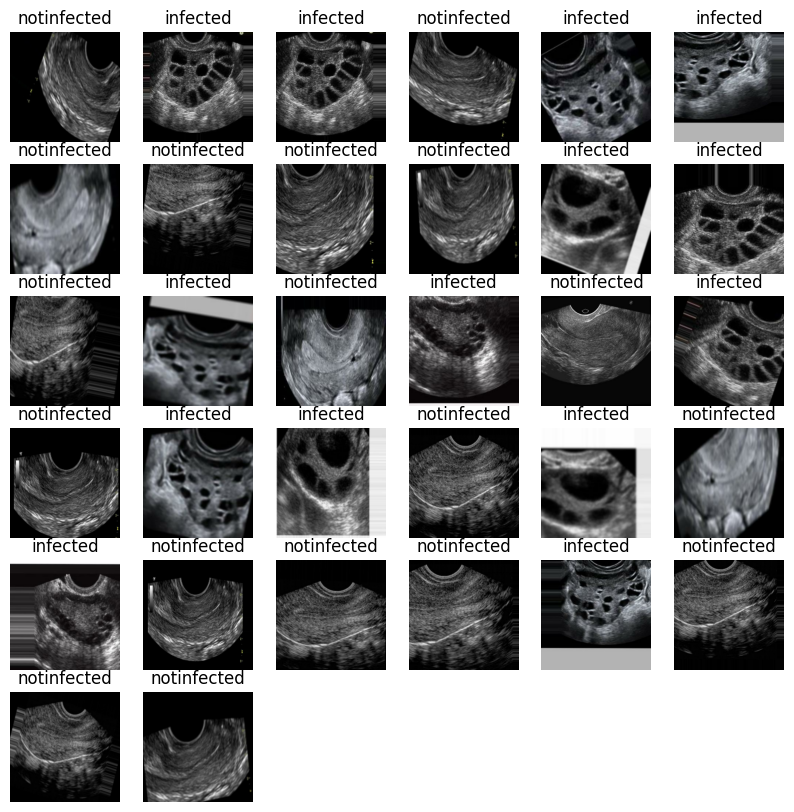

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(2):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [ ]:
# The desired result was not achieved
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    #class_names=None,
    shuffle=True,
    seed=12,
    validation_split= 0.15,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split= 0.15,
    seed=12,
    subset="validation",
    image_size=(img_height, img_width),
    #label_mode="categorical",
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test,
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)
"""

# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             #width_shift_range=0.2,
                             #height_shift_range=0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=20,
                             validation_split=0.2,
                             fill_mode='nearest'
                             )
# prepare an iterators for each dataset
train_ds = datagen.flow_from_directory(directory,
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=batch_size,
                                       subset='training',
                                       seed=12)
# prepare an iterators for each dataset
val_ds = datagen.flow_from_directory( directory,
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=batch_size,
                                       subset='validation',
                                       seed=12)


Found 1920 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test,
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 244 files belonging to 2 classes.


In [ ]:
earlyStopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1,patience=15)

In [ ]:
import tensorflow as tf

# Set device to GPU if available, otherwise use CPU
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

# Define and compile your model with the chosen device
with tf.device(device):
    model = Sequential([
        Conv2D(12, (5,5),padding='SAME',activation='relu', input_shape=(img_height, img_width, 3)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(8, (5,5),padding='SAME',activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(4, (5,5),padding='SAME',activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(2, activation='softmax')
    ])

opt=Adam(learning_rate=0.03)
model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[earlyStopping],
    batch_size=batch_size,
    verbose=1,
    epochs=20)

Epoch 1/20
60/60 [==============================] - 184s 3s/step - loss: 0.6315 - accuracy: 0.7328 - val_loss: 0.3859 - val_accuracy: 0.8271
Epoch 2/20
60/60 [==============================] - 38s 643ms/step - loss: 0.4293 - accuracy: 0.7552 - val_loss: 0.6838 - val_accuracy: 0.6542
Epoch 3/20
60/60 [==============================] - 41s 688ms/step - loss: 0.3095 - accuracy: 0.8589 - val_loss: 0.3276 - val_accuracy: 0.8583
Epoch 4/20
60/60 [==============================] - 41s 680ms/step - loss: 0.1869 - accuracy: 0.9245 - val_loss: 0.2282 - val_accuracy: 0.9125
Epoch 5/20
60/60 [==============================] - 37s 621ms/step - loss: 0.1328 - accuracy: 0.9365 - val_loss: 0.2342 - val_accuracy: 0.9292
Epoch 6/20
60/60 [==============================] - 41s 682ms/step - loss: 0.1487 - accuracy: 0.9411 - val_loss: 0.2122 - val_accuracy: 0.9104
Epoch 7/20
60/60 [==============================] - 39s 648ms/step - loss: 0.1258 - accuracy: 0.9474 - val_loss: 0.1683 - val_accuracy: 0.9292
E

In [ ]:
model.summary()

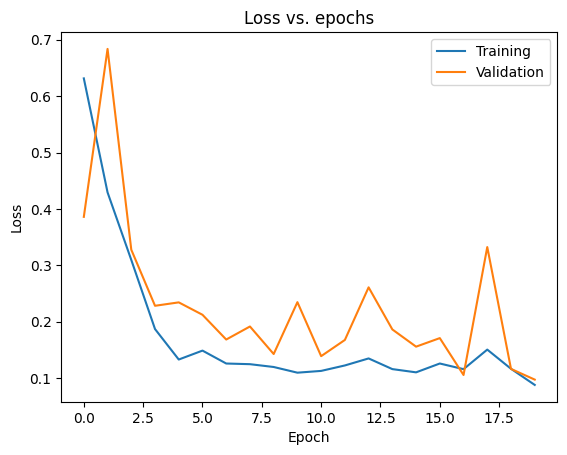

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

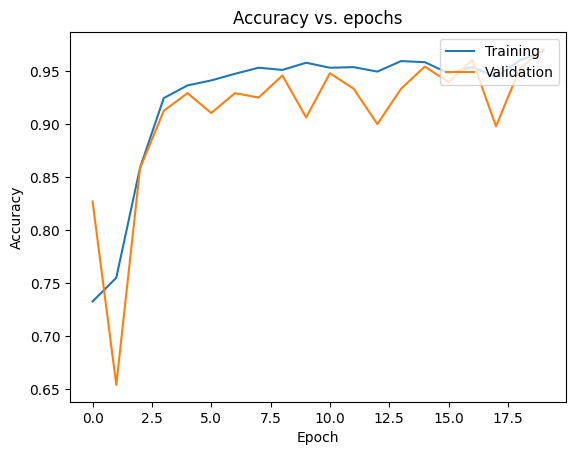

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()


In [ ]:
model.evaluate(val_ds)

15/15 [==============================] - 7s 452ms/step - loss: 0.1479 - accuracy: 0.9354


[0.14786916971206665, 0.9354166388511658]

In [ ]:
model.save('my_model.keras')

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load the saved model
saved_model = tf.keras.models.load_model('model.h5')

# Make predictions on the validation dataset
Y_pred_prob = saved_model.predict(val_ds)
y_pred = np.argmax(Y_pred_prob, axis=1)

# Get the true labels from the validation dataset
Y_true = []
for _, labels_batch in val_ds:
    Y_true.extend(labels_batch.numpy())
Y_true = np.array(Y_true)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_true, y_pred)

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
